# Support Vector Machine

En este notebook clasificaremos si una instancia tiene alto poder adquisitivo mediante support vector machine.

Se utilizarán tres preprocessings diferentes:
* Las variables utilizadas en la primera parte del trabajo práctico
* PCA con 75% de varianza explicada.
* Variables que generen una buena separación con tSNE.

In [1]:
# Modelo
from sklearn.svm import SVC

# Entrenamiento
from sklearn.model_selection import train_test_split, GridSearchCV

# Preprocessing
import utils
from preprocessing import preprocessing_base_parte_1
from preprocessing import preprocessing_significantes
from preprocessing import preprocessing_mejores_por_arbol

# Metrics
from sklearn.metrics import roc_curve, plot_roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

# Plots
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# No supervisado
from sklearn.manifold import TSNE

### Preprocessing Base

In [12]:
df = utils.get_data()

### Modelo 1 - Preprocessing parte 1

Este árbol será entrenado con las siguientes variables:

* **Ganancia/Pérdida declara en la bolsa argentina**: `ganancia_perdida_declarada_bolsa_argentina`
* **Edad**: `edad`
* **Rol familiar registrado**: `rol_familiar_registrado`
* **Años estudiados**: `anios_estudiados`

In [81]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
Y = df['tiene_alto_valor_adquisitivo']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, Y, random_state=112)

X_train_1, X_test_1 = preprocessing_base_parte_1(X_train_1, X_test_1)

In [83]:
model = SVC() # Al entrenar probability = False, al predecir probability = True
params = [{'kernel': ['poly'], 'C': np.logspace(-4, 1, 6), 'degree': range(2, 4)},
          {'kernel': ['rbf'], 'C': np.logspace(-3, 2, 12) ,'gamma': [0.01, 0.001, 0.0001]}
         ]
gscv = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, cv=4, verbose=4)

In [84]:
gscv.fit(X_train_1, y_train_1)

Fitting 4 folds for each of 48 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:  8.1min finished


GridSearchCV(cv=4, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                          'degree': range(2, 4), 'kernel': ['poly']},
                         {'C': array([1.00000000e-03, 2.84803587e-03, 8.11130831e-03, 2.31012970e-02,
       6.57933225e-02, 1.87381742e-01, 5.33669923e-01, 1.51991108e+00,
       4.32876128e+00, 1.23284674e+01, 3.51119173e+01, 1.00000000e+02]),
                          'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']}],
             scoring='roc_auc', verbose=4)

In [85]:
svm = gscv.best_estimator_
svm.probability = True

svm.fit(X_train_1, y_train_1)

SVC(C=100.0, gamma=0.0001, probability=True)

In [86]:
print(classification_report(y_test_1,svm.predict(X_test_1)))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      6182
           1       0.82      0.53      0.64      1959

    accuracy                           0.86      8141
   macro avg       0.85      0.75      0.78      8141
weighted avg       0.86      0.86      0.85      8141



El resultado es sorprendente, un modelo con un accuracy de 86%, bastante alto, pero lo que más nos sorprendió fue su precisión:
* 82% de precisión para los unos
* 87% de precisión para los ceros

Son buenos números.

Veamos cómo se comporta la matriz de confusión

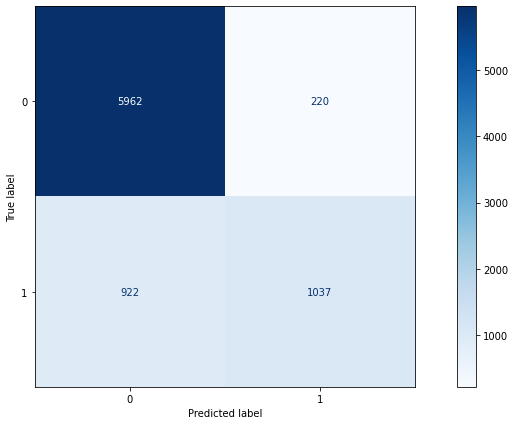

In [87]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(svm, X_test_1, y_test_1, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax)
plt.show()

Vemos que, si bien el resultado de la clasificación nos da una buena impresión, la matriz de confusión nos muestra que la cantidad de falsos negativos es altísima, dejando en claro que estamos dejando pasar gran cantidad de unos.

Veamos el score RocAUC

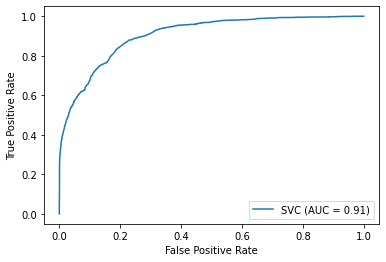

In [88]:
plot_roc_curve(svm, X_test_1, y_test_1)

In [89]:
roc_auc_score(y_test_1, svm.predict_proba(X_test_1)[:, 1])

0.9053210517980291

Un valor de RocAUC interesante! Será entonces un modelo para tener en cuenta.

### Modelo 2 - Preprocessing Significantes 75%

La idea será clasificar con SVM si la instancia tiene alto o bajo poder adquisitvo mediante sus atributos transformados en base a una Standarización y luego una reducción dimensional (PCA) del 75% de la varianza explicada.

In [4]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')].copy()
X = pd.get_dummies(X, drop_first=True)
Y = df['tiene_alto_valor_adquisitivo'].copy()


X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, Y, random_state=112)

# Explica el 75% de la varianza
X_train_2, X_test_2 = preprocessing_significantes(X_train_2, X_test_2, 0.75)

/home/lukas/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [7]:
model = SVC() # Al entrenar probability = False, al predecir probability = True
params = [{'kernel': ['poly'], 'C': np.logspace(-4, 1, 6), 'degree': range(2, 4)},
          {'kernel': ['rbf'], 'C': np.logspace(-3, 2, 12) ,'gamma': [0.01, 0.001, 0.0001]}
         ]

In [8]:
gscv2 = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, cv=4, verbose=4)

In [9]:
gscv2.fit(X_train_2, y_train_2)

Fitting 4 folds for each of 48 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 23.4min finished


GridSearchCV(cv=4, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                          'degree': range(2, 4), 'kernel': ['poly']},
                         {'C': array([1.00000000e-03, 2.84803587e-03, 8.11130831e-03, 2.31012970e-02,
       6.57933225e-02, 1.87381742e-01, 5.33669923e-01, 1.51991108e+00,
       4.32876128e+00, 1.23284674e+01, 3.51119173e+01, 1.00000000e+02]),
                          'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']}],
             scoring='roc_auc', verbose=4)

In [21]:
print("Los parámetros que mejor score obtuvieron para SVM fueron:", gscv2.best_params_)
print("Con un Score (RocAUC) de: ", round(gscv2.best_score_, 4))

Los parámetros que mejor score obtuvieron para SVM fueron: {'C': 100.0, 'gamma': 0.001, 'kernel': 'rbf'}
Con un Score (RocAUC) de:  0.8914


In [15]:
svm2 = gscv2.best_estimator_
svm2.probability = True
svm2.verbose=4
svm2.fit(X_train_2, y_train_2, )

[LibSVM]

SVC(C=100.0, gamma=0.001, probability=True, verbose=4)

In [16]:
print(classification_report(y_test_2,svm2.predict(X_test_2)))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90      6182
           1       0.70      0.57      0.63      1959

    accuracy                           0.84      8141
   macro avg       0.79      0.75      0.76      8141
weighted avg       0.83      0.84      0.83      8141



Unos resultados decentes. Un accuracy de 84%, similar al obtenido para el baseline de la parte1.

Veamos la matriz de confusión

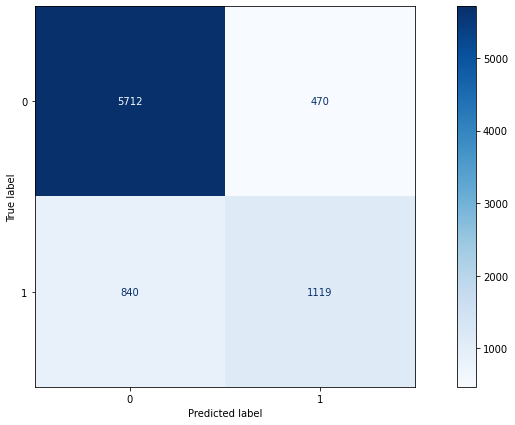

In [23]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(svm2, X_test_2, y_test_2, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax)
plt.show()

Podemos ver de la matriz de confusión algunas similitudes con la obtenida previamente.

Hay muchísimos falsos negativos, cercanos a los verdaderos positivos. Esto se podía ver en el pobre Recall de unos obtenido.


De todas formas, veamos la curva ROC y su puntuación

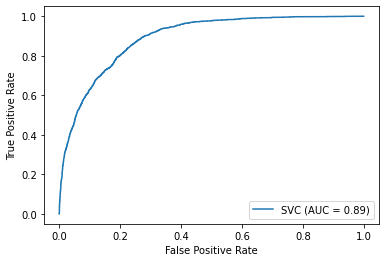

In [24]:
plot_roc_curve(svm2, X_test_2, y_test_2)

In [76]:
roc_auc_score(y_test_2, svm2.predict_proba(X_test_2)[:, 1])

0.8901071942468617

Una curva buena con un Score decente.

### Modelo 3 - Mejor variables por árbol

In [23]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')].copy()
X = pd.get_dummies(X, drop_first=False)
Y = df['tiene_alto_valor_adquisitivo'].copy()


X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, Y, random_state=112)

X_train_3, X_test_3 = preprocessing_mejores_por_arbol(X_train_3, X_test_3)

In [24]:
params = [{'kernel': ['poly'], 'C': np.logspace(-4, 1, 6), 'degree': [2, 3]},
          {'kernel': ['rbf'], 'C': np.logspace(-3, 2, 12) ,'gamma': [0.01, 0.001, 0.0001]}
         ]
model = SVC()

gscv3 = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, verbose = 4)

In [25]:
gscv3.fit(X_train_3, y_train_3)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  9.7min finished


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                          'degree': [2, 3], 'kernel': ['poly']},
                         {'C': array([1.00000000e-03, 2.84803587e-03, 8.11130831e-03, 2.31012970e-02,
       6.57933225e-02, 1.87381742e-01, 5.33669923e-01, 1.51991108e+00,
       4.32876128e+00, 1.23284674e+01, 3.51119173e+01, 1.00000000e+02]),
                          'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']}],
             scoring='roc_auc', verbose=4)

In [27]:
print("Los parámetros que mejor score obtuvieron para SVM fueron:", gscv3.best_params_)
print("Con un Score (RocAUC) de: ", round(gscv3.best_score_, 4))

Los parámetros que mejor score obtuvieron para SVM fueron: {'C': 100.0, 'gamma': 0.0001, 'kernel': 'rbf'}
Con un Score (RocAUC) de:  0.9123


Vemos que el Score obtenido para ser bastante bueno. Veamos cómo se comporta con los datos de validación.

In [28]:
svm3 = gscv3.best_estimator_
svm3.probability = True
svm3.verbose=4
svm3.fit(X_train_3, y_train_3)

[LibSVM]

SVC(C=100.0, gamma=0.0001, probability=True, verbose=4)

In [29]:
print(classification_report(y_test_3,svm3.predict(X_test_3)))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      6182
           1       0.82      0.55      0.66      1959

    accuracy                           0.86      8141
   macro avg       0.85      0.76      0.79      8141
weighted avg       0.86      0.86      0.85      8141



Vemos que el modelo parece ser decente! Un 86% de Accuracy, buenas métricas para precisión.

Como siempre, las métricas para recall de unos es muy baja.

Veamos la matriz de confusión.

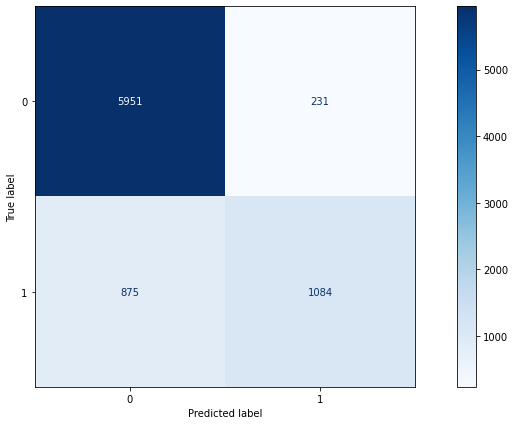

In [30]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(svm3, X_test_3, y_test_3, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax)
plt.show()

Generalmente se obtuvieron mejores valores que antes. Pero tenemos el mismo problema de muchísimos falsos negativos.

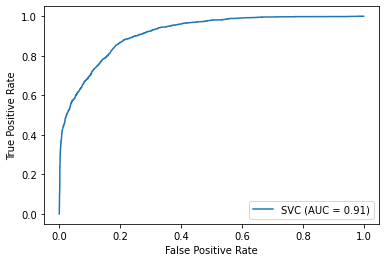

In [31]:
plot_roc_curve(svm3, X_test_3, y_test_3)

In [32]:
roc_auc_score(y_test_3, svm3.predict_proba(X_test_3)[:, 1])

0.9142121927200922

### Conclusiones


En general teníamos pocas expectativa a SVM ya que es difícil ver si los datos tienen una distribución separable en el espacio, pero resultó en modelos buenos. El último particularmente resultó en uno muy bueno, siendo hasta ahora el mejor modelo armado.

# Persistiendo los modelos

In [33]:
import pickle

In [35]:
pickle.dump(svm, open("Modelos/SVM/svm1.pickle", "wb" ))
pickle.dump(svm2, open("Modelos/SVM/svm2.pickle", "wb" ))
pickle.dump(svm3, open("Modelos/SVM/svm3.pickle", "wb" ))

# Predicción de HoldOut

Usaremos para predecir el SVM obtenido para el preprocessing mejores variables según árbol.

In [3]:
svm3 = pickle.load(open("Modelos/SVM/svm3.pickle", "rb"))

In [6]:
def holdout():
    dfv = utils.get_data()
    Xv = dfv[dfv.columns.drop('tiene_alto_valor_adquisitivo')]
    Xv = pd.get_dummies(Xv)

    ids, X = utils.get_holdout_data()
    X = pd.get_dummies(X)

    notInHoldout=[]
    for c in Xv.columns:
        if c not in X.columns:
            notInHoldout.append(c)
    X[notInHoldout] = 0

    Xv, X = preprocessing_mejores_por_arbol(Xv, X)
    return ids, X

In [7]:
ids, X = holdout()

In [8]:
utils.escribir_holdout(svm3.predict(X), "4 - SVM", ids)